### Classification on imbalanced data
Tensorflow 2.0에 맞게 다시 Tensorflow를 살펴볼 필요가 있다고 느껴져서 <a href="https://www.tensorflow.org/?hl=ko">Tensorflow 정식 홈페이지</a>에 나와있는 예제부터 전반적인 Tensorflow 사용법을 먼저 익히는 Post가 된다.  
<br>

#### 필요한 Library import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import os
import io
import requests
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# matplotlib setting
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### GOAL
이번 Post의 목적은 다음과 같다.
- Model의 결과를 어떻게 분석하고 Visualization할 수 있는가?
- Imbalanced Data를 어떻게 Preprocessing할 수 있는가?

<br>

#### Data processing and exploration
이전 Post <a href="https://wjddyd66.github.io/tnesorflow2.0/Tensorflow2.0(20)/">Classify Structured data with feature columns</a>마찬가지로 먼저 Data를 Download받고 어떻게 구성되어있는지 먼저 살펴보자.  

Data는 <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Kaggle Credit Card Fraud data set</a>을 사용한다.  
Data의 Format은 CSV로서 사용하기 위해서 Pandas를 활용하여 Dataframe형태로 바꾸고 Data가 어떻게 구성되어있는지 알아본다.

In [2]:
URL = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
# Download and read Dataset
x = requests.get(url=URL).content 
raw_df = pd.read_csv(io.StringIO(x.decode('utf8')))
# Top 5 Data Check
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Describe Dataset
위에서 다운로드 받은 몇몇 Dataset의 Column에 대한 자세한 내용을 <code>.describe</code>를 통하여 확인한다.  

**Imbalanced Feature**  
Imbalanced Feature이란 Feature의 값이 한쪽으로 매우 치우쳐져 있는 상태이다.  
이러한 Dataset의 Feature로 인하여 Model의 성능은 잘 안나오거나 혹은, Backpropagation이 잘 진행되지 않는 경우가 많이 발생하게 될 것이다.  
Ex) <a href="https://wjddyd66.github.io/tnesorflow2.0/Tensorflow2.0(15)/#3-2-trainning">SSD</a>에서는 Object Detection의 과정에서 대부분의 경우가 Background 즉, 배경이라 판단되는 Neg가 많이 포함되어서 positive:negative의 비율을 초반에 1:3으로서 되도록 Hard negative mining을 진행하였다.  

**참조(np.bincount)**  
알아두면 좋은 numpy의 활용법이다.  
각각의 Data의 개수가 어떻게 되는치 표현해주는 Code이다. 예시는 아래와 같다.  

```python
count_1 = np.bincount([1, 1, 2, 2, 3, 3], minlength=6)
count_2 = np.bincount([0, 0, 0, 1, 1, 1])

print(count_1) #[0 2 2 2 0 0]
print(count_2) #[3 3]
```
<br>

In [3]:
# Describe Some Feature
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Examine the class label imbalance
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Example:\n  Total: {} \n  Positive: {} ({:.2f}% of total)'.format(total,pos,100*pos/total))

Example:
  Total: 284807 
  Positive: 492 (0.17% of total)


#### Clean, split and normalize the data
위의 Kaggle Dataset에서 31개의 columns중에서 몇몇 Preprocessing과정이 필요한 columns를 살펴 볼 수 있을 것 이다.  

1. Tiem, Amount -> 이 2개의 Columns는 다른 V1 ~ V28의 Columns보다 값이 매우 큰 것을 확인할 수 있다. 따라서 Normalization으로서 Preprocessing 작업이 필요하다.
2. Class -> 위에서도 살펴볼 수 있듯이 Imbalanced한 Column이다. Positive는 전체 Total의 0.17%에 불가하다는 것을 알 수 있다.  

먼저, Time, Amount의 Columns에 대하여 해당 Tensorflow 2.0 Guide에서는 다음과 같이 Preprocessing을 진행하게 된다.
- Time: 값이 불분명하고 어떤것을 의미하는지 저확히 알 수 없으니 제거한다.
- Amount: Log를 통하여 Normalization을 실시하게 된다.

위와 같은 Preprocessing을 거친 뒤 Dataset을 Train, Validation, Test로서 나누게 된다.  

데이터 전처리가 끝난 뒤에는 <a href="">sklearn.preprocessing.StandardScalar</a>를 통하여 Z-Normalization(mean-0, std-1)을 실시한다.  
<br>

**Why Dataset Split?**  
대부분의 책에서는 Model의 성능을 올리기 위하여 Dataset을 Split한다고 나와있지만 정확히 나와있지 않다. 개인적으로 공부하고 Model을 검증하면서 느낀 각각의 Dataset의 의미는 다음과 같다.  
- Train: 내가 세운 가설로서 Model이 Trainning되는지 알아보기 위한 Dataset이다. **최종적인 목표는 결국 Model을 Training하는 것 이므로, Shuffle을 하거나 Augmentation등을 통하여 Model이 좀 더 학습을 잘 할 수 있도록 Customization하는  과정이 대부분 필요하다.**
- Validation: Model을 Train하는 과정에서 Overfitting을 확인 할 수 있다. Underfitting의 경우는 Model을 훈련하면서 Accuracy or Loss를 확인하면 된다. 하지만 Overfitting관련되서는 Train도 중 확인할 수 있는 방법은 Validation Dataset이 유일하다.
- Test: 결국에는 Model에 Training과 Validation의 경우에도 Sampling을 한 Dataset으로서 Model을 완성한 것이라고 생각할 수 있다. 따라서 우리가 원하는 **모든 상황에서 잘 작동하는 Model을 검증하기 위해서는 Model의 Training에 사용하지 않은 새로운 Dataset으로서 확인하는 것이 중요하다.**



In [5]:
cleaned_df = raw_df.copy()

# Delete Time column
cleaned_df.pop('Time')

# Log-Space Normalization
eps = 0.001 # -Infinity prevention
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

# Split Data of Train, Validation, Test
train_df, test_df = train_test_split(cleaned_df,test_size=0.2)
train_df, val_df = train_test_split(train_df,test_size=0.2)

# Label Pop
train_labels = np.array(train_df.pop('Class'))
# For Checking Imbalanced Data Column
bool_train_labels = train_labels != 0

val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

# Feature
train_features = np.array(train_df)
val_features = np.array(val_df)
test_featuers = np.array(test_df)

# Normalization of all Columns
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_featuers)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


# Check Dataset
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


#### Look at the data distribution
실제 Imbalanced Data를 살펴보기 위하여 Positive, Negative에 따른 Columns에 대한 Distribution을 시각화하여 살펴보자.  
<a href="https://seaborn.pydata.org/generated/seaborn.jointplot.html">seaborn.sns.jointplot</a>을 통하여 Distribution을 Visualization하여 확인할 수 있다.  

Distribution을 확인하면 Positive Distribution이 극단값을 더 많이 가지고 있는 것을 확인할 수 있다.

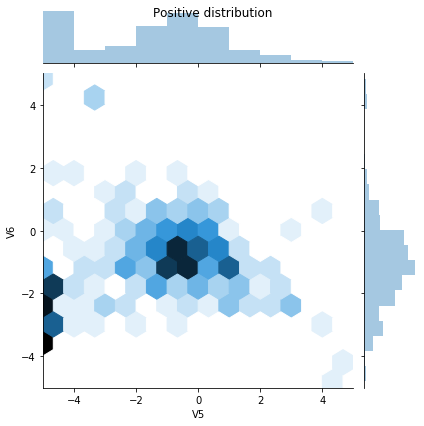

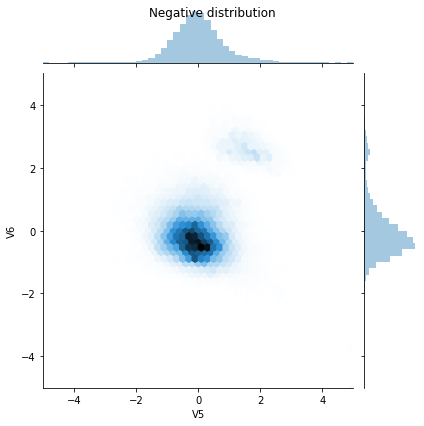

In [6]:
# Split Data to Positive or Negative
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

# Visualization Distribution of Data
sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

#### Define the model and metrics
실제 Model을 구성하고 Training의 결과를 Metirc을 활용하여 살펴본다.  

**참조(Metric)**  
Keras의 Metric을 잘 모르겠다면 아래 링크를 참조하자.  
<a href="https://wjddyd66.github.io/keras/Keras(5)/#케라스-콜백과-텐서보드를-사용한-딥러닝-모델-검사와-모니터링">Keras-Metric</a>  

**참조(Understanding useful metrics)**  
사용하는 Metric중에서 많이 사용하는 Metrics를 몇 개 소개하자면 다음과 같다.  
- False: 잘 못 Classify한 결과
- True: 잘 Classify한 결과
- Accuracy: 정확도($\frac{true samples}{total samples}$)
- Precision: ($\frac{true positives}{treu potitives + false positives}$)
- Recall: ($\frac{true positives}{true potivies + false negatives}$)

위의 Useful Metrics의 자세한 내용은 링크를 참조하자. <a href="https://wjddyd66.github.io/tnesorflow2.0/Tensorflow2.0(18)/">mAP</a>  

**참조(Early Stoppping)**  
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping">tf.keras.callbacks.EarlyStopping</a>를 통하여 더 이상 개선의 여지가 없을 때 학습을 종료시키는 콜백 함수이다.  

<code>keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')</code>
- monitor: 관찰하고자 하는 항목. Ex) Accuracy, Loss
- min_delta: 개선되고 있다고 판단하기 위한 최소 변화량. 만약 변화량이 min_delta보다 적은 경우에는 개선이 없다고 판단.
- patience: 개선이 없다고 바로 종료하지 않고 개선이 없는 Epoch를 얼마나 기다려 줄 것인가를 지정
- verobse: 얼마나 자세하게 정보를 표시할 것인가를 지정한다. Ex) 0, 1, 2
- mode: 관찰 항목에 대하여 개선이 없다고 판단하기 위한 기준을 지정한다. 
 - auto: 관찰하는 이름에 따라 자동으로 지정한다.
 - min: 관찰하고 있는 항목이 감소되는 것을 멀출 때 종료한다.
 - max: 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료한다.
 

In [7]:
# Use Keras Metrics for Model Training Checking
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Build the Model
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])
    
    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

# Hyperparameter Setting
EPOCHS = 100
BATCH_SIZE = 2048

# Define the Early_stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

# Model Check
model = make_model()
model.summary()

# Test Model
model.predict(train_features[:10])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


array([[0.03100261],
       [0.08420261],
       [0.04211326],
       [0.04435135],
       [0.14044134],
       [0.19501121],
       [0.17531972],
       [0.09391932],
       [0.19638194],
       [0.32220805]], dtype=float32)

#### Optional: Set the correct initial bias
<a href="http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines">A Recipe for Training Neural Networks: "init well"</a>에서는 bias를 Initialization하는 방법에 대하여 소개하고 있다.  

**대부분의 Bias는 0으로서 초기화하고, ReLU를 Activation Function으로 사용하는 경우 작은값(0.001)으로서 초기화를 많이 하였다. <a href="https://wjddyd66.github.io/dl/NeuralNetwork-(5)-Others/#가중치의-초깃값">Weight는 Xavier나 He의 방법</a>으로서 초기화 하였지만, Bias의 경우에는 Guide에서도 나와있지만, 초기화 하는 다양한 방법이 존재하나, 결과는 좋지 않기 때문에 Tensorflow 2.0 Guide에서도 Optional로서 남겨 둔 것 같다.(모든 Layer의 Bias를 Initialize 한 것이 아닌 마지막 Output의 Bias만 지정하였다.)**

In [8]:
# No initial bias
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('-'*5,'No Initial Bias','-'*5)
print("Loss: {:0.4f}".format(results[0]))
print()

# Initial bias
initial_bias = np.log([pos/neg])
print('Initial Bias: ',initial_bias)
print()

# Check Result
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('-'*5,'Initial Bias','-'*5)
print("Loss: {:0.4f}".format(results[0]))

----- No Initial Bias -----
Loss: 0.1950

Initial Bias:  [-6.35935934]

----- Initial Bias -----
Loss: 0.0159


#### Save & Load Model
실제 Model의 Training된 결과를 저장하고 불러와서 결과를 확인하는 방법이다.  
실제 Model의 결과는 Bias를 초기화 하였을 때랑, 아닌 때를 구별하여서 결과를 보기 쉽게 Visualization하였다.

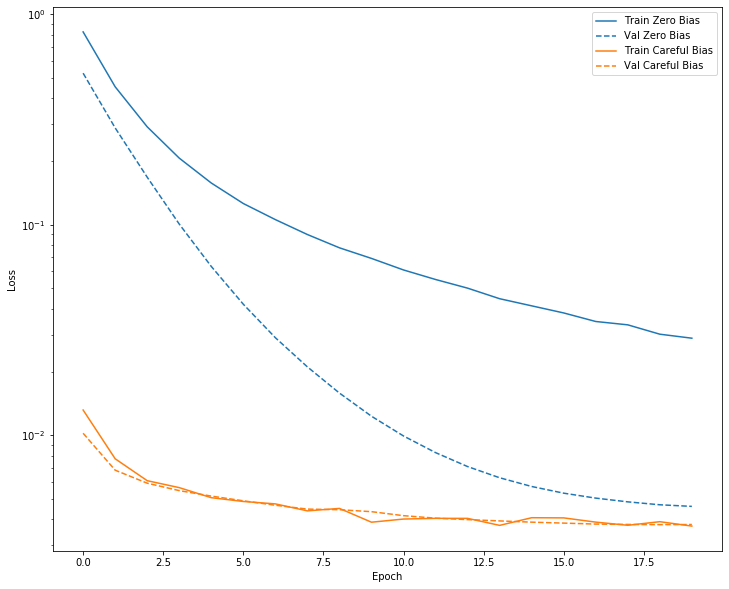

In [9]:
# Save Model Weights
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

# Load Model with No Bias Initialize
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

# Load Model with Bias Initialize
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

# Funtion of Visuzliation
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()
    
# Visualization of Result
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

#### Train the model & Check Result
위의 Train의 결과는 Epoch를 매우 적게하여 확인하였을 경우이다.  
실제 Epoch를 Hyperparameter setting한 횟수만큼 하여 Model의 결과를 위의 Metric에서 언급한, Accuracy, Loss, Precision, Recall 4개의 분야에서 Visuzliation 하여 살펴보자.

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


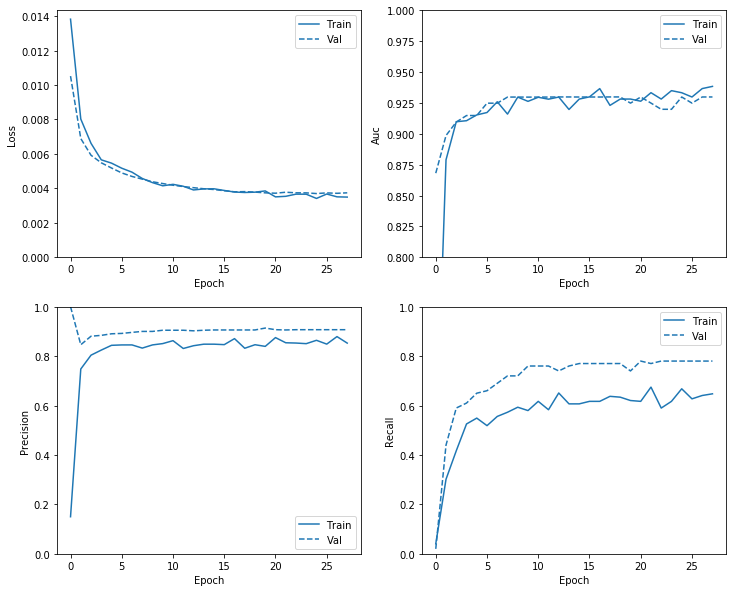

In [10]:
# Model Training With Bias Initialize
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    verbose = 0)

# Visualization the Result of history
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'loss':
            # the maximum of Subplot0's y value
            # if plt.ylim()[0] -> the minimum of Subplot0's y value
            plt.ylim([0, plt.ylim()[1]])
            
        elif metric == 'auc':
            plt.ylim([0.8,1])
            
        else:
            plt.ylim([0,1])

        plt.legend()
        
plot_metrics(baseline_history)

#### Evaluate metrics
Test Dataset으로 Confusion Matrix를 구하여 Metrics를 평가한다.  
<img src="https://t1.daumcdn.net/cfile/tistory/99EEC8335993B47330">
<br>
사진 참조:<a href="https://better-today.tistory.com/1">better-today 블로그</a>

loss :  0.00333997395457523
tp :  73.0
fp :  9.0
tn :  56856.0
fn :  24.0
accuracy :  0.99942064
precision :  0.8902439
recall :  0.7525773
auc :  0.9172725

Legitimate Transactions Detected (True Negatives):  56856
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  73
Total Fraudulent Transactions:  97


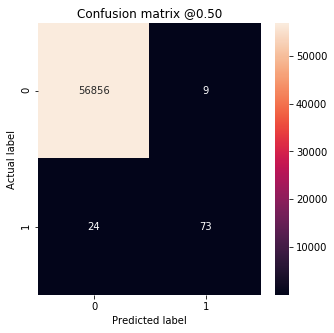

In [11]:
# Test Prediction
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

# Plot Confusion Matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

# Model Result
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

# Check the Result Visualization
plot_cm(test_labels, test_predictions_baseline)

#### ROC Curve
ROC Curve의 예를 살펴보면 다음과 같다.  
<img src="https://t1.daumcdn.net/cfile/tistory/998C0F4A5B274BFE27" style="cursor: pointer;max-width:100%;height:auto" width="400" height="300" filename="sphx_glr_plot_roc_002.png" filemime="image/jpeg">
<br>
사진 참조:<a href="https://yamalab.tistory.com/82">yamalab Blog</a>  

기본적으로 Confusion Matrix로서 결과를 살펴볼 수 있으나 뭔가 시각적으로 와닿지 않아서 사용하는 방법이다.  
위의 Blog의 ROC Curve에 대한 설명은 다음과 같이 나타나 있다.  
>계단처럼 각지게 되어있는 영역은, 임계값을 0에서 1로 단계적으로 변화시키면서 나타나는 현상이다. 그래서 Decision Tree와 같은 Tree 계열의 알고리즘은 임계값에 따라 변하는 node가 달라지기 때문에 Logistic regression과 같은 곡선 모양의 loss function을 가지는 알고리즘과 달리 조금 더 각진 모양의 ROC 커브가 나오는 것이다.  
만약 양성을 양성이라 판단할 확률(P(X))이 높고, 음성을 음성이라 판단할 확률이 높다면 그 모델의 ROC Curve는 좌측 상단에 수렴하는 형태의 curve가 될 것이다. 이러한 모델이 민감도와 특이도 모두 좋은 수치를 보이는 모델이고, 단순히 Acc가 높은 모델보다 훌륭한 모델이라고 할 수 있다. 일반적인 성능비교는 curve의 아래 부분 영역, 즉 AUC(Area Under Curve)를 통해 비교하게 된다.
>

또한 이러한 ROC Curve를 그리기 위하여 <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html">sklearn.metrics.roc_curve</a>를 사용하여 값을 구하게 된다.

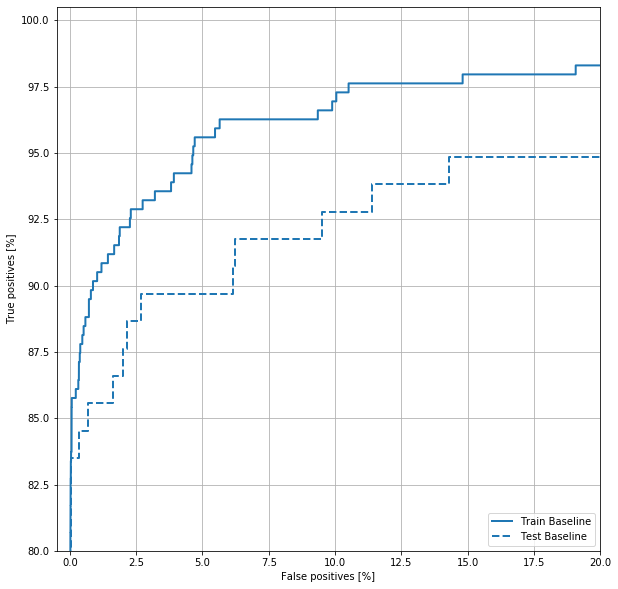

In [12]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    # First Setting of matplotlib's figsize -> mpl.rcParams['figure.figsize'] = (12, 10)
    # Chage width and length to equal length
    ax = plt.gca()
    ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### Solution of Imbalanced Data
**위의 과정은 Data의 Format은 어떻게 되어있고 특성은 어떻게 되어있는 지 확인하고, 많이 사용하는 Visualization방법을 통하여 결과를 시각화 하였다.**  
**이제부터는 본래 Post의 목적인 Imbalanced Data를 어떻게 Preprocessing을 통하여 Model의 성능을 높히는지 알아본다.**  

#### Class Weights
**현재 Imbalanced Data의 문제는 Negative의 Sample이 Positive에 비하여 매우 많다는 문제이다. 따라서 Tensorflow 2.0 Guide에서 첫번째로 권하는 방법은 Potivie의 Weights를 늘리는 방법이다.**  
즉, Label에 따라서 Weights를 다르게 하여, 적은 수의 Example의 Backpropagation과정에서 큰 값을 Model에 전달한다는 의미(**pay more attention이라는 표현**으로 나타냄)이다.

In [13]:
# Class Weights
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


#### Train & Check Results
위의 Visualization의 방법대로 Model을 Training하고 결과를 확인한다.  
Model Training시에 Class별로 Weight를 달리하기 위하여 <code>model.fit()</code>에서 class_weight option을 사용한다.  


**주의사항**  
필자는 처음 Class Weights를 적용한다고 하였을때, 단순한 Optimizer SGD만을 생각하여 불가능 일 것이라고 생각하였다.  
이에 대한 해답으로서 Tensorflw 2.0 Guide는 다음과 같이 설명하고 있다.  
>Note: Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like optimizers.SGD, may fail. The optimizer used here, optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.
>

매우 중요한 부분이다.  
위의 내용을 요약하자면, **Imbalanced Data를 Preprocessing 하기 위하여 Class weights방법을 사용하지만 이러한 결과로서 Backpropagation에 영향을 많이 주기 때문에 Optimizer를 잘 골라야 한다. SGD와 같이 기울기의 크기를 바로 계산하여 Update하는 방식은 사용할 수 없으므로, Scaling Change에 영향을 상대적으로 덜 받는 Adam같은 Optimizer를 사용하여야 한다.**  
참고: <a href="https://wjddyd66.github.io/dl/NeuralNetwork-(3)-Optimazation2/">Optimizer 종류</a>

In [14]:
# Build the Model
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose = 0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping


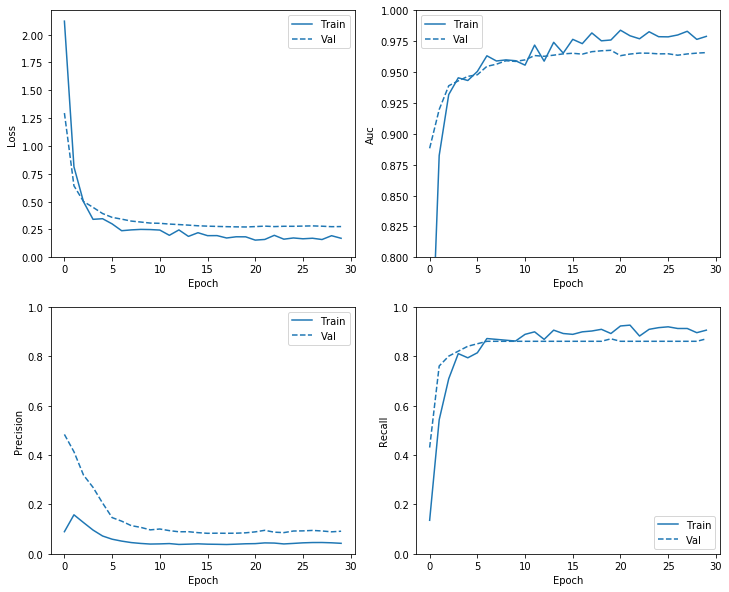

In [15]:
# Check the training history
plot_metrics(weighted_history)

loss :  0.08774819382790464
tp :  85.0
fp :  1233.0
tn :  55632.0
fn :  12.0
accuracy :  0.97814333
precision :  0.06449165
recall :  0.87628865
auc :  0.9781131

Legitimate Transactions Detected (True Negatives):  55632
Legitimate Transactions Incorrectly Detected (False Positives):  1233
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  97


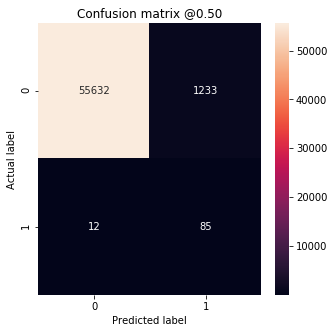

In [16]:
# Evaluate metrics
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

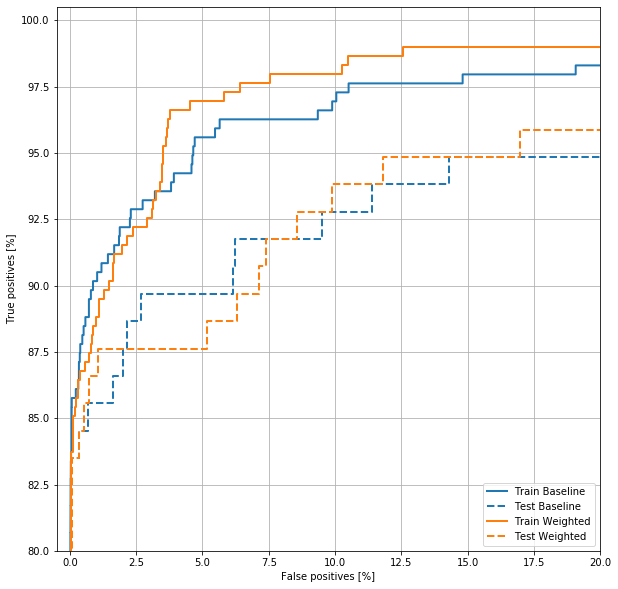

In [17]:
# Plot ROC
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

#### Oversampling
minority class를 Oversampling하는 방법이다.  
현재 적은수의 Potive Sample의 개수를 Negative 개수만큼 늘린다.

In [18]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

print('Number of Positive Dataset: ',len(pos_labels))
print('Number of Negative Dataset: ', len(neg_labels))

# Increasing the number of positives
ids = np.arange(len(pos_features))
choices = np.random.choice(ids,len(neg_features))

# Repositive Data
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

print('Number of Oversampling Positive Data: ',len(res_pos_labels))

# Concate the negative and positive
resampled_features = np.concatenate([res_pos_features,neg_features])
resampled_labels = np.concatenate([res_pos_labels,neg_labels])

# Shuffle
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

print('Shape of Resampled Feature: ',resampled_features.shape)

Number of Positive Dataset:  295
Number of Negative Dataset:  181981
Number of Oversampling Positive Data:  181981
Shape of Resampled Feature:  (363962, 29)


#### Making Dataset
Oversampling된 Data를 활용하여 실제 Model에 넣을 Tensor로서의 변환 및 배치 처리 등을 실시한다.

In [19]:
# Dataset -> Tensor
BUFFER_SIZE = len(resampled_labels)

resampled_ds = tf.data.Dataset.from_tensor_slices((resampled_features,resampled_labels))
resampled_ds = resampled_ds.shuffle(BUFFER_SIZE).repeat()
resampled_ds = resampled_ds.batch(BATCH_SIZE)

# Check Result
for features, label in resampled_ds.take(1):
    print('Features: ',features.numpy())
    print()
    print('Label: ',label.numpy())
    
resampled_steps_per_epoch = np.ceil(len(resampled_labels)/BATCH_SIZE)

Features:  [[ 0.22153056  1.11872228 -2.84264633 ...  0.95790877  0.94409832
  -1.4523672 ]
 [-5.          4.42126039 -5.         ...  2.80901191  0.66726183
   0.81949769]
 [-1.64030509  1.62702478 -2.15234607 ... -0.77054442 -2.21069022
   0.57239537]
 ...
 [-2.6442241   4.18255523 -5.         ...  1.55162433 -0.50522976
   1.82443643]
 [-1.05153865  1.57974659 -0.49490846 ...  0.03712224 -0.15081618
  -0.42670675]
 [-0.77365516  1.38699652 -0.99266866 ... -0.04880501 -0.61958439
  -1.4523672 ]]

Label:  [1 1 1 ... 1 1 1]


#### Train & Check Results
실제 Oversampling된 Data를 활용하여 Model을 Training하고 위의 과정처럼 결과를 확인한다.  
**중요한 점은 Oversampling을 통하여 Data가 Balanced한 형태로 변하였으므로, Bias를 특정 값으로서 Initialize할 필요가 없다는 것 이다.**

In [20]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
val_ds = val_ds.batch(BATCH_SIZE)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds,
    verbose = 0)

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


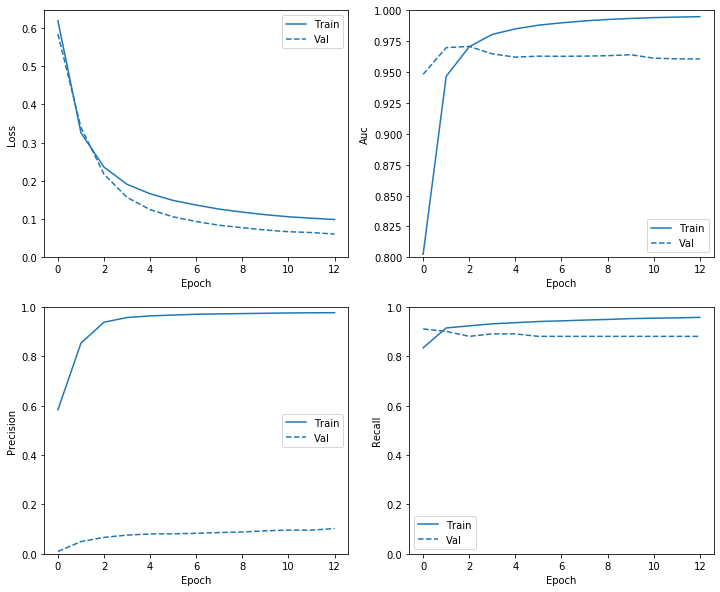

In [21]:
# Check training history
plot_metrics(resampled_history )

#### Re-Train
위의 결과를 확인하면 약간의 Overfitting이 발생된 것을 확인할 수 있다.  
이를 해결하기 위하여 Tensorflow 2.0 Guide에서는 <code>model.fit</code>에서 steps_per_epoch의 수를 매우 낮추었다.  
이러한 현상의 원인은 **Balanced한 Data는 쉽게 Training이 가능하고 따라서 Epoch가 늘어나게 되는 경우 Overfitting의 위험이 많이 커진다고 한다.**

In [22]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds),
    verbose = 0)

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


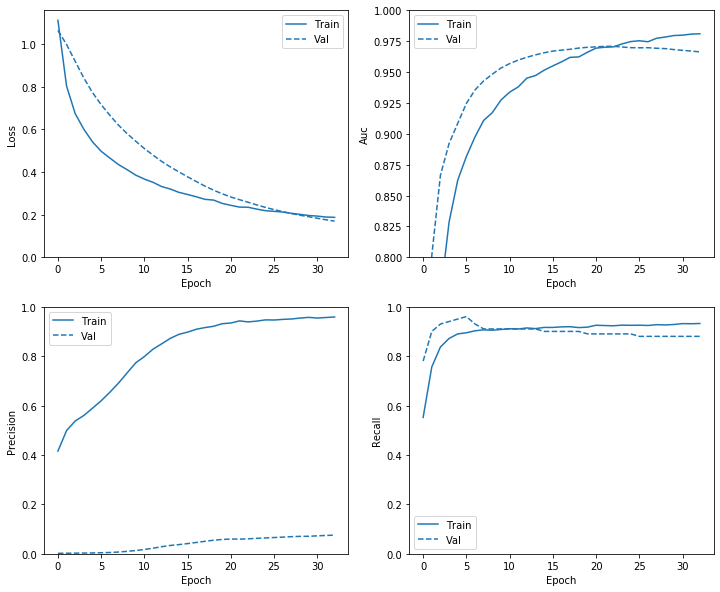

In [23]:
# Check training history
plot_metrics(resampled_history )

loss :  0.25787307716672464
tp :  87.0
fp :  1765.0
tn :  55100.0
fn :  10.0
accuracy :  0.9688389
precision :  0.046976242
recall :  0.8969072
auc :  0.97114503

Legitimate Transactions Detected (True Negatives):  55632
Legitimate Transactions Incorrectly Detected (False Positives):  1233
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  97


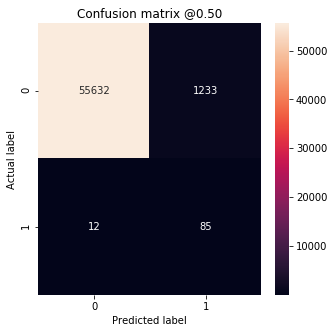

In [24]:
# Evaluate metrics
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

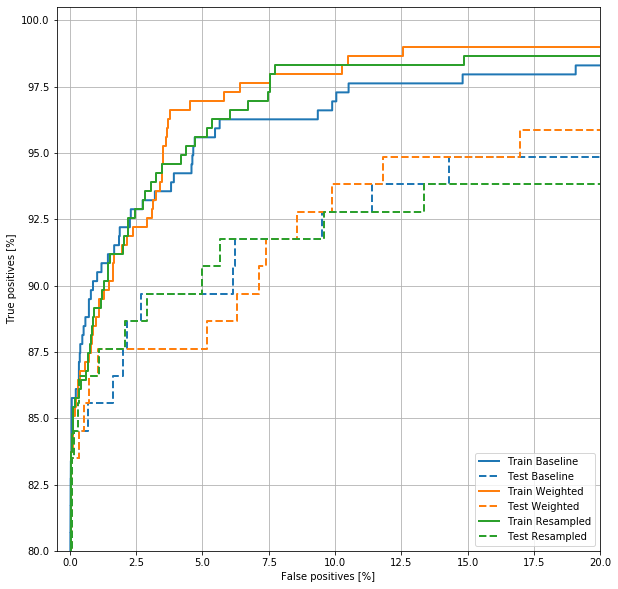

In [25]:
# Plot the ROC
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')